In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ricgomes/global-fashion-retail-stores-dataset")

print("Path to dataset files:", path)

100%|██████████| 224M/224M [00:01<00:00, 133MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ricgomes/global-fashion-retail-stores-dataset/versions/24


In [ ]:
data = pd.read_csv(path+'/transactions.csv')

In [ ]:
exchange_rates = pd.DataFrame({
    "Currency": ["USD", "CNY", "GBP", "EUR"],
    "to_USD": [1.00, 0.14, 1.33, 1.16]
})
data_temp = data.merge(exchange_rates, on='Currency', how='left')
data_temp['to_USD'] = data_temp['to_USD'].fillna(1.0)
data['Line Total'] = data_temp['Line Total'] * data_temp['to_USD']
del data_temp

In [ ]:
import pandas as pd

df = data.copy()

# Đảm bảo cột Date Normalize là datetime
df['Date Normalize'] = pd.to_datetime(data['Date'])
df['Date Normalize'] = df['Date Normalize'].dt.normalize()

# Tổng hợp doanh số theo ngày
df_daily = df.groupby('Date Normalize')['Line Total'].sum().reset_index()
df_daily = df_daily.sort_values('Date Normalize')

print(df_daily.head())


  Date Normalize   Line Total
0     2023-01-01  759856.5580
1     2023-01-02  177565.8705
2     2023-01-03  158566.6598
3     2023-01-04  164006.1005
4     2023-01-05  157792.9851


In [ ]:
df_daily['dayofweek'] = df_daily['Date Normalize'].dt.dayofweek
df_daily['month'] = df_daily['Date Normalize'].dt.month
df_daily['is_weekend'] = (df_daily['dayofweek'] >= 5).astype(int)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Các cột đưa vào mô hình
features = ['Line Total', 'dayofweek', 'month', 'is_weekend']

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_daily[features])

# Dự đoán doanh số → y = Invoice Total (cột 0 sau khi scale)


In [ ]:
def create_dataset(data, time_steps=14):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])
        y.append(data[i, 0])   # giá trị doanh số tại ngày i
    return np.array(X), np.array(y)

TIME_STEPS = 14
X, y = create_dataset(scaled_data, TIME_STEPS)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (794, 14, 4)
y shape: (794,)


In [ ]:
total_len = len(X)
train_size = int(total_len * 0.7)
val_size = int(total_len * 0.2)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print("Train shapes: X={}, y={}".format(X_train.shape, y_train.shape))
print("Validation shapes: X={}, y={}".format(X_val.shape, y_val.shape))
print("Test shapes: X={}, y={}".format(X_test.shape, y_test.shape))

Train shapes: X=(555, 14, 4), y=(555,)
Validation shapes: X=(158, 14, 4), y=(158,)
Test shapes: X=(81, 14, 4), y=(81,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

model = Sequential([
    SimpleRNN(64, return_sequences=True, input_shape=(TIME_STEPS, X.shape[2])),
    SimpleRNN(32),
    Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse'
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 14, 64)         │         4,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,553 (29.50 KB)

 Trainable params: 7,553 (29.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)


Epoch 1/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.1246 - val_loss: 0.0152
Epoch 2/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0103 - val_loss: 0.0042
Epoch 3/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0080 - val_loss: 0.0197
Epoch 4/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0131 - val_loss: 0.0055
Epoch 5/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0085 - val_loss: 0.0019
Epoch 6/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0063 - val_loss: 0.0022
Epoch 7/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 8/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 9/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0054 - val_loss: 9.1646e-04
Epoch 10/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0045 - val_loss: 0.0014
Epoch 11/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0037 - val_loss: 8.4314e-04
Epoch 12/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1

In [ ]:
# 7. DỰ BÁO VÀ ĐÁNH GIÁ (PREDICT)
train_predict = model.predict(X_train)
val_predict = model.predict(X_val)
test_predict = model.predict(X_test)

# Đảo ngược chuẩn hóa để về giá trị thực

# Create dummy arrays with 4 features for inverse_transform
train_predict_rescaled = np.zeros((train_predict.shape[0], scaled_data.shape[1]))
train_predict_rescaled[:,0] = train_predict[:,0] # Place predictions in the first column ('Line Total')
train_predict = scaler.inverse_transform(train_predict_rescaled)[:,0]

val_predict_rescaled = np.zeros((val_predict.shape[0], scaled_data.shape[1]))
val_predict_rescaled[:,0] = val_predict[:,0]
val_predict = scaler.inverse_transform(val_predict_rescaled)[:,0]

test_predict_rescaled = np.zeros((test_predict.shape[0], scaled_data.shape[1]))
test_predict_rescaled[:,0] = test_predict[:,0]
test_predict = scaler.inverse_transform(test_predict_rescaled)[:,0]

# Inverse transform y_train, y_val, y_test as well, ensuring they have the correct shape
y_train_rescaled = np.zeros((y_train.shape[0], scaled_data.shape[1]))
y_train_rescaled[:,0] = y_train
y_train_inv = scaler.inverse_transform(y_train_rescaled)[:,0]

y_val_rescaled = np.zeros((y_val.shape[0], scaled_data.shape[1]))
y_val_rescaled[:,0] = y_val
y_val_inv = scaler.inverse_transform(y_val_rescaled)[:,0]

y_test_rescaled = np.zeros((y_test.shape[0], scaled_data.shape[1]))
y_test_rescaled[:,0] = y_test
y_test_inv = scaler.inverse_transform(y_test_rescaled)[:,0]


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Metrics for Test Set
inv_true_test = y_test_inv
inv_pred_test = test_predict

mae_test = mean_absolute_error(inv_true_test, inv_pred_test)
mse_test = mean_squared_error(inv_true_test, inv_pred_test)
rmse_test = np.sqrt(mse_test)
mape_test = np.mean(np.abs((inv_true_test - inv_pred_test) / np.maximum(inv_true_test, 1e-7))) * 100
r2_test = r2_score(inv_true_test, inv_pred_test)

print("===== TEST SET MODEL PERFORMANCE =====")
print(f"MAE  : {mae_test:,.2f}")
print(f"MSE  : {mse_test:,.2f}")
print(f"RMSE : {rmse_test:,.2f}")
print(f"MAPE : {mape_test:.2f}%")
print(f"R2   : {r2_test:.4f}")

===== TEST SET MODEL PERFORMANCE =====
MAE  : 73,675.22
MSE  : 27,409,574,120.30
RMSE : 165,558.37
MAPE : 22.40%
R2   : 0.5862


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Metrics for Train Set
inv_true_train = y_train_inv
inv_pred_train = train_predict

mae_train = mean_absolute_error(inv_true_train, inv_pred_train)
mse_train = mean_squared_error(inv_true_train, inv_pred_train)
rmse_train = np.sqrt(mse_train)
mape_train = np.mean(np.abs((inv_true_train - inv_pred_train) / np.maximum(inv_true_train, 1e-7))) * 100
r2_train = r2_score(inv_true_train, inv_pred_train)

print("===== TRAIN SET MODEL PERFORMANCE =====")
print(f"MAE  : {mae_train:,.2f}")
print(f"MSE  : {mse_train:,.2f}")
print(f"RMSE : {rmse_train:,.2f}")
print(f"MAPE : {mape_train:.2f}%")
print(f"R2   : {r2_train:.4f}")

===== TRAIN SET MODEL PERFORMANCE =====
MAE  : 25,607.70
MSE  : 1,044,477,566.71
RMSE : 32,318.38
MAPE : 9.88%
R2   : 0.9752


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Metrics for Validation Set
inv_true_val = y_val_inv
inv_pred_val = val_predict

mae_val = mean_absolute_error(inv_true_val, inv_pred_val)
mse_val = mean_squared_error(inv_true_val, inv_pred_val)
rmse_val = np.sqrt(mse_val)
mape_val = np.mean(np.abs((inv_true_val - inv_pred_val) / np.maximum(inv_true_val, 1e-7))) * 100
r2_val = r2_score(inv_true_val, inv_pred_val)

print("===== VALIDATION SET MODEL PERFORMANCE =====")
print(f"MAE  : {mae_val:,.2f}")
print(f"MSE  : {mse_val:,.2f}")
print(f"RMSE : {rmse_val:,.2f}")
print(f"MAPE : {mape_val:.2f}%")
print(f"R2   : {r2_val:.4f}")

===== VALIDATION SET MODEL PERFORMANCE =====
MAE  : 92,348.02
MSE  : 28,369,863,541.91
RMSE : 168,433.56
MAPE : 16.62%
R2   : 0.6488


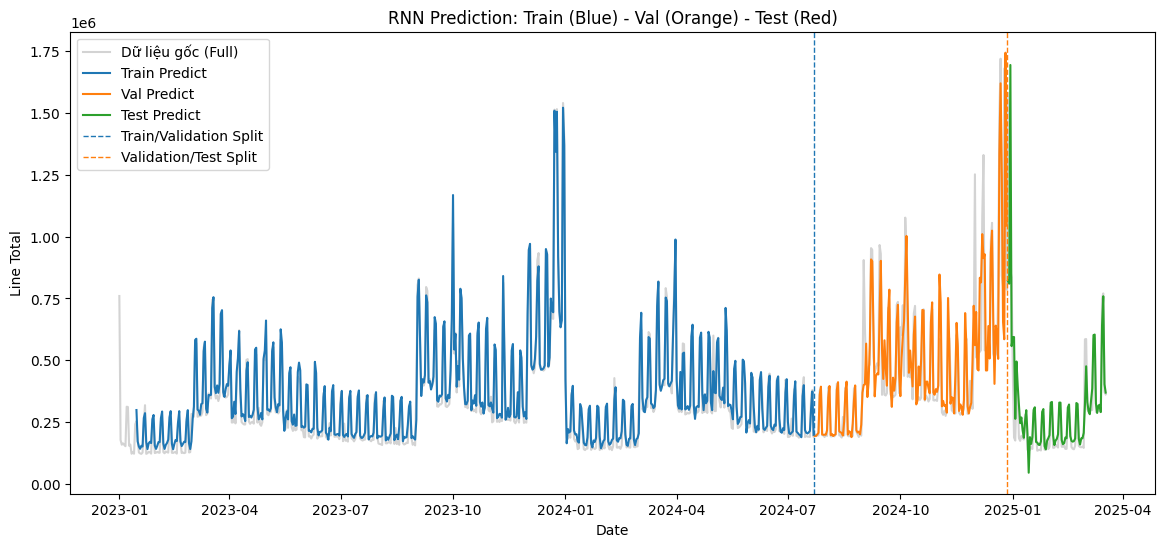

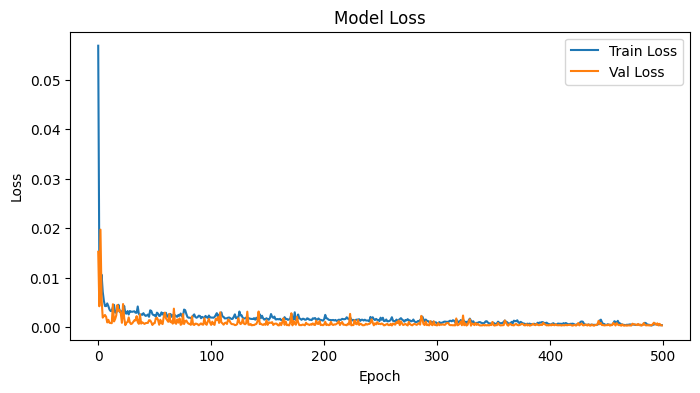

In [ ]:
import matplotlib.pyplot as plt
# 8. VẼ BIỂU ĐỒ (VISUALIZATION)
plt.figure(figsize=(14,6))

# Plot the original data (unscaled Line Total from df_daily)
plt.plot(df_daily['Date Normalize'], df_daily['Line Total'], label='Dữ liệu gốc (Full)', color='lightgray')

# Calculate correct starting indices for predictions relative to the original df_daily
train_start_idx = TIME_STEPS
val_start_idx = TIME_STEPS + len(train_predict)
test_start_idx = TIME_STEPS + len(train_predict) + len(val_predict)

# Create index ranges for plotting predictions, aligning them with df_daily's dates
train_dates = df_daily['Date Normalize'][train_start_idx : train_start_idx + len(train_predict)]
val_dates = df_daily['Date Normalize'][val_start_idx : val_start_idx + len(val_predict)]
test_dates = df_daily['Date Normalize'][test_start_idx : test_start_idx + len(test_predict)]

# Plot Train predictions
plt.plot(train_dates, train_predict, label='Train Predict', color='#1f77b4', linewidth=1.5)

# Plot Val predictions
plt.plot(val_dates, val_predict, label='Val Predict', color='#ff7f0e', linewidth=1.5)

# Plot Test predictions
plt.plot(test_dates, test_predict, label='Test Predict', color='#2ca02c', linewidth=1.5)

# Add vertical lines to split train, validate, and test sets
if not train_dates.empty:
    plt.axvline(x=train_dates.iloc[-1], color='#1f77b4', linestyle='--', linewidth=1, label='Train/Validation Split')
if not val_dates.empty:
    plt.axvline(x=val_dates.iloc[-1], color='#ff7f0e', linestyle='--', linewidth=1, label='Validation/Test Split')

plt.title('RNN Prediction: Train (Blue) - Val (Orange) - Test (Red)')
plt.xlabel('Date')
plt.ylabel('Line Total')
plt.legend()
plt.show()

# Vẽ biểu đồ Loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()